### Imports


In [37]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import sys  # update paths
import os  # import os in order to find relative path
import glob
import numpy as np 
import matplotlib.pyplot as plt
import re
import h5py

from collections import Counter

sys.path.append('../../scresonators')
sys.path.append('../../meas_analysis')
sys.path.append('../../')

from slab.datamanagement import SlabFile
import handy as hy 

import fit_resonator.resonator as scres
import time 
import seaborn as sns
import scipy.constants as cs
from scipy.optimize import curve_fit
import scipy.special as special 

min_power = -100
atten = -50 
#import importlib 
#importlib.reload(scres)

pth_base = '../../../../JJ_fab/Coherence Sample /Resonators Measurement/240719/data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions: grab list of resonators and files, fit resonator func, sweep through powers/temps 

In [3]:
def get_resonators(folder, pth, pattern):
    
    # List of files
    pth = pth + folder
    file_list0 = os.listdir(pth)
    #print(len(file_list0))

    tokens=[]
    # Get a list of resonators 
    for i in range(len(file_list0)):
        tokens.append(re.findall(pattern, file_list0[i]))

    values = [int(token) for sublist in tokens for token in sublist]
    resonators = set(values)

    frequency = Counter(values)
    print(frequency)

    resonators = np.array(list(resonators))
    resonators.sort()
    return resonators, file_list0

def fit_resonator(data, filename, output_path, fit_type='DCM', plot=None, pre='circle'):
    # fit type DCM, CPZM
    my_resonator = scres.Resonator()
    my_resonator.outputpath = output_path 
    my_resonator.filename = filename
    my_resonator.from_columns(data['freqs'], data['amps'], data['phases'])
    # Set fit parameters

    MC_iteration = 4
    MC_rounds = 1e3
    MC_fix = []
    manual_init = None
    my_resonator.preprocess_method = pre # Preprocess method: default = linear
    my_resonator.filepath = './' # Path to fit output
    # Perform a fit on the data with given parameters
    my_resonator.fit_method(fit_type, MC_iteration, MC_rounds=MC_rounds, MC_fix=MC_fix,manual_init=manual_init, MC_step_const=0.3)
    output = my_resonator.fit(plot)
    return output 

# conf_array = [Q_conf, Qi_conf, Qc_conf, Qc_Re_conf, phi_conf, w1_conf]
# Q, Qc, Frequency, Phase 

def analyze_sweep(directories, plot=None):
    pattern0 = r'res_(\d+)_\d{2}dbm'

    # Initialize dict 
    resonators, file_list = get_resonators(directories[0],pth_base, pattern0)
    res_params = [None] * len(resonators)
    for i in range(len(resonators)):
        res_params[i] = {'freqs':[], 'phs':[], 'q':[], 'qi':[], 'qc':[], 'qi_phi':[], 'pow':[]}
    
    # Each directory is a temperature 
    for i in range(len(directories)): 
        start = time.time()
        print(i)
        output_path = './procdata_' + directories[i] + '/'
        resonators, file_list0 = get_resonators(directories[i], pth_base, pattern0)
        pth = pth_base + directories[i]
        for j in range(len(resonators)): 
            # Grab all the files for a given resonator, then sort by power. 
            pattern = 'res_{:d}_'.format(resonators[j]) + '\d{2}dbm'
            file_list = [file for file in file_list0 if re.match(pattern, file)]
            file_list.sort()
            file_list = file_list[::-1]
            print(file_list)
            params, err, power = [], [], []
            for k in range(len(file_list)):
                data, attrs = hy.prev_data(pth, file_list[k])

                # Reformat data for scres package
                data['phases'] = np.unwrap(data['phases'][0]*np.pi/180)
                data['freqs']=data['fpts'][0]
                data['amps']=data['mags'][0]

                # Skip really noisy ones since they are slow
                pow_curr = data['vna_power'][0]            
                if pow_curr < min_power: 
                    continue
                power.append(data['vna_power'][0])
                
                try:
                    output = fit_resonator(data, file_list[k], output_path, 'DCM', plot)    
                    params.append(output[0])
                    err.append(output[1])
                except: 
                    print('fit failed')
                    params.append([np.nan,np.nan,np.nan,np.nan])
                    err.append([np.nan,np.nan,np.nan,np.nan, np.nan, np.nan])

            # Put all the data for a given resonator/temp in arrays. 
            power=np.array(power)
            res_params[j]['pow'].append(power)
            
            q = np.array([params[k][0] for k in range(len(params))])
            qc = np.array([params[k][1] for k in range(len(params))])
            freq = np.array([params[k][2] for k in range(len(params))])
            phase = np.array([params[k][3] for k in range(len(params))])
            qi_phi = 1/(1/q-1/qc)
            Qc_comp = qc / np.exp(1j * phase)
            Qi = (q ** -1 - np.real(Qc_comp ** -1)) ** -1

            res_params[j]['q'].append(q)
            res_params[j]['qc'].append(qc)
            res_params[j]['freqs'].append(freq)
            res_params[j]['phs'].append(phase)
            res_params[j]['qi_phi'].append(qi_phi)
            res_params[j]['qi'].append(Qi)
            
            end = time.time()
            print('Time elapsed: ', end-start)
            inds = power >= min_power
            fig, ax = plt.subplots(2,1, figsize=(6,5), sharex=True)
            ax[0].plot(power[inds], Qi[inds], '.', markersize=6)
            ax[0].set_ylabel('$Q_i$')
            ax[1].plot(power[inds], qc[inds], '.', markersize=6)
            ax[1].set_ylabel('$Q_c$')
            ax[1].set_xlabel('Power (dBm)')
            fig.suptitle('$f_0 = $ {:3.3f} GHz'.format(freq[0]/1e9))
            fig.tight_layout()
            plt.savefig('/Users/sph/' + 'resonator_power_'+str(directories[i]) + str(resonators[j]) + '.png', dpi=300)

    for i in range(len(resonators)):
        for key in res_params[i].keys():
            res_params[i][key] = np.array(res_params[i][key])

    return res_params

### Run sweep 

In [2]:
# Define directory manually  

directories = ['sample1_power_sweep_2']
res_params0 = analyze_sweep([dir_base])

In [7]:
# Initialize the directories list for a temperature sweep 
folder_path = pth_base  # Replace with the actual folder path

directories = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
directories = sorted(directories)
dir_base = directories[2]

#directories = directories[3:-1]
print(directories)

res_data=[]

temps = np.array([float(d[7:]) for d in directories])
print(temps)
max_temp = 1500
inds = np.where(temps < max_temp)
temps = temps[inds]
directories = np.array(directories)[inds]
inds = np.argsort(temps)
temps = temps[inds]
directories = directories[inds]
print(directories)

res_params = analyze_sweep(directories)

[ 130.  200.  270.  400.  450.  500.  600.  800. 1400.]
['240517_130' '240518_200' '240519_270' '240520_400' '240522_450'
 '240521_500' '240522_600' '240523_800' '240525_1400']


### Plot qualities vs temp and power for 1 resonator 

In [ ]:
i=5
cbar=False # Use color bar instead of legend 
xval = 'temp' 
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 1

inds = np.argsort(temps)
en = 1e-3*temps[inds]*cs.k/cs.h/res_params[i]['freqs'][inds,0]
if xval == 'temp': 
    x = temps[inds]
    xlab = 'Temperature (mK)'
else:     
    x=en
    xlab = '$k_B T / h f_0$'

min_freq = np.nanmin(res_params[i]['freqs'][inds,:])
sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[1])

# Temperature sweep 
fig, ax = plt.subplots(4,1, figsize=(6,9), sharex=True) 
for j in range(res_params[i]['pow'].shape[1]):
    ax[0].plot(x, res_params[i]['qi'][inds,j], '.-')
    #ax[1].plot(temps[inds], res_params[i]['qi'][inds,j]/res_params[i]['qi'][inds,j][0], '.-')
    ax[1].plot(x, res_params[i]['qi'][inds,j]/np.max(res_params[i]['qi'][inds,j]), '.-')
    ax[2].plot(x, res_params[i]['qc'][inds,j], '.-')
    ax[3].plot(x, (res_params[i]['freqs'][inds,j]-min_freq)/min_freq, '.-')

if cbar: 
    norm = plt.Normalize(np.min(temps), np.max(temps))
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    ax[1].figure.colorbar(sm, ax=ax[1])

    norm = plt.Normalize(np.min(res_params[i]['pow']), np.max(res_params[i]['pow']))
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    ax[0].figure.colorbar(sm, ax=ax[0])

ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_i(0)$')
ax[2].set_ylabel('$Q_c$')
ax[3].set_xlabel('Temperature (mK)')
ax[3].set_xlabel(xlab)
ax[3].set_ylabel('$\Delta f/f_0$')

fig.tight_layout()
sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[0]+1)

fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 
#sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[0]-2)

ax[0].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0], '.-', label='60') #str(temps[j])+ ' mK'
ax[1].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0]/np.max(res_params0[i]['qi'][0]), '.-', label='60') #str(temps[j])+ ' mK'

# Plot power dependence 
for j in inds:
    ax[0].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:], '.-', label=int(temps[j])) #str(temps[j])+ ' mK'    
    ax[1].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:]/np.max(res_params[i]['qi'][j,:]), '.-')
    #ax[1].plot(res_params[i]['pow'][0,:], res_params[i]['qi'][j,:]/res_params[i]['qi'][j,:][0], '.-')


ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_i(0)$')
ax[1].set_xlabel('Power (dBm)')

ax[0].legend(fontsize=8)
fig.tight_layout()

### Plot minimum power temperature sweep for all resonators 

In [ ]:
xval = 'temp' 
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.linewidth'] = 1.5
inds = np.argsort(temps)
en = 1e-3*temps[inds]*cs.k/cs.h/res_params[i]['freqs'][inds,0]
if xval == 'temp': 
    x = temps[inds]
    xlab = 'Temperature (mK)'
else:     
    x=en
    xlab = '$k_B T / h f_0$'

j=0
# Temperature sweep 
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 
for i in range(len(res_params)):
    inds2 = res_params[i]['qi'][inds,j]/np.max(res_params[i]['qi'][inds,j]) > 0.72
    min_freq = np.nanmin(res_params[i]['freqs'][inds,:])
    x = temps[inds2]

    ax[0].plot(x, res_params[i]['qi'][inds2,j]/np.max(res_params[i]['qi'][inds2,j]), '.-')
    ax[1].plot(x, (res_params[i]['freqs'][inds2,j]-min_freq)/min_freq, '.-')

ax[0].set_ylabel('$Q_i/Q_{i,max}$')
ax[1].set_xlabel(xlab)
ax[1].set_ylabel('$\Delta f/f_0$')
plt.savefig('/Users/sph/' + 'temp_sweep.png', dpi=300)

### Plot minimum temperature power sweep for all 

In [ ]:
res_params0=res_params
#colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
colors = ['#4053d3', '#b51d14', '#ddb310','#658b38','#7e1e9c', '#75bbfd', '#cacaca']
sns.set_palette(colors)
sns.set_palette('coolwarm', 7)

#sns.set_palette('husl', n_colors=6)
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 

plt.rcParams['lines.markersize'] = 4
pitch = [10, 12, 14, 16, 4, 6, 8]
for i in range(len(res_params0)):
    l = round(np.min(res_params0[i]['freqs']/1e9),4)
    #l = pitch[i]
    ax[0].semilogy(res_params0[i]['pow'][0], res_params0[i]['qi'][0], '.-', label=l) #str(temps[j])+ ' mK'
    ax[1].semilogy(res_params0[i]['pow'][0], res_params0[i]['qi'][0]/np.max(res_params0[i]['qi'][0]), '.-', label=l) #str(temps[j])+ ' mK'
    #ax[0].legend()

ax[1].set_xlabel('Power')
ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_{i,max}$')
#ax[0].set_title('60 mK')
ax[1].legend()
fig.tight_layout()
fig.savefig('/Users/sph/' + 'Qi_pow.png', dpi=300)


### Plot Qc 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
freqs = np.array([np.min(res_params[i]['freqs'])/1e9 for i in range(len(res_params))])
qc = np.array([np.min(res_params[i]['qc']) for i in range(len(res_params))])

ax.plot(pitch, qc, '.', markersize=10)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('$Q_c$')
fig.tight_layout()

fig.savefig('/Users/sph/' + 'Qc_vs_freq.png', dpi=300)

>Error when trying to write parameters on plot
>cannot convert float infinity to integer
Exception: name 'quit' is not defined
Failed to plot DCM fit for <fit_resonator.resonator.ResonatorData object at 0x1628469d0>
Unrecognized file format: png
 Please use png, pdf, ps, eps or svg.


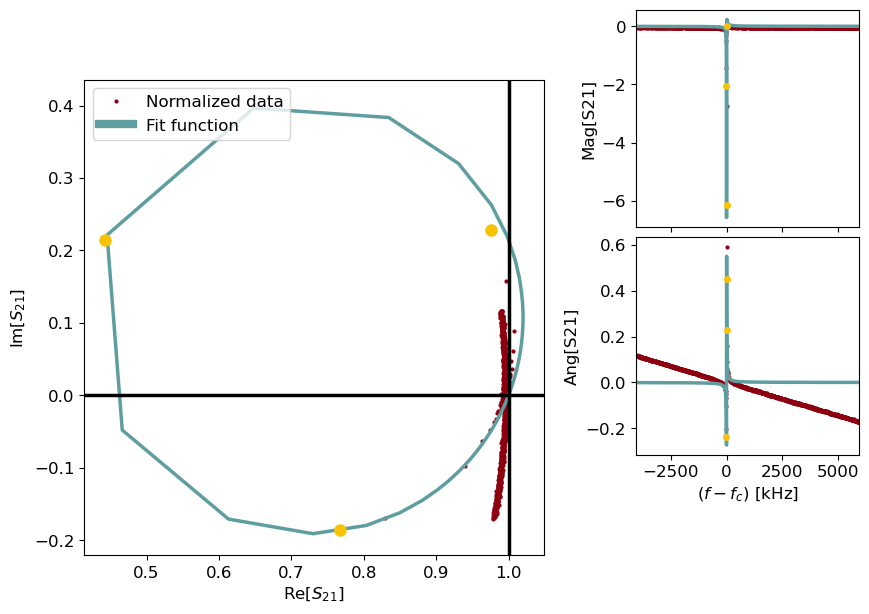

In [42]:

pth = pth_base     
i=9
#    if pow_curr >= min_power: 

try:

    data, attrs = hy.prev_data(pth, file_list[i])

                # Reformat data for scres package
    data['phases'] = np.unwrap(data['phases'][0])
    data['freqs']=data['fpts'][0]
    data['amps']=data['mags'][0]

    output_path = '2409'
    pow_curr = data['vna_power'][0]            
    output = fit_resonator(data, file_list[i], output_path, 'DCM')    
except: 
    print('fit failed')  

### Fit all the resonators in directory without savign data or sorting, just for looking at plots. 

-70.0
-60.0
-50.0
-40.0
-30.0
-20.0


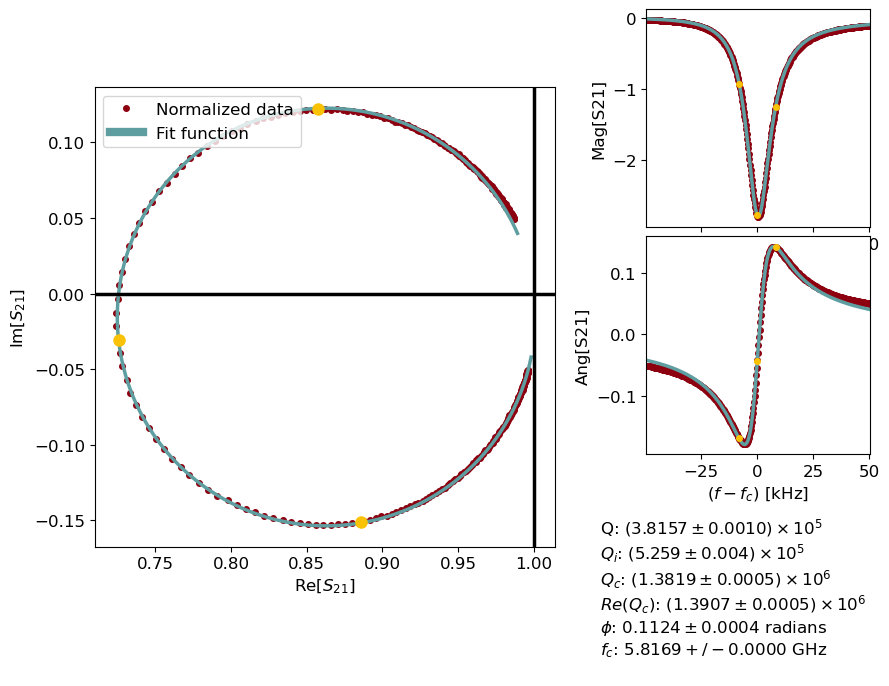

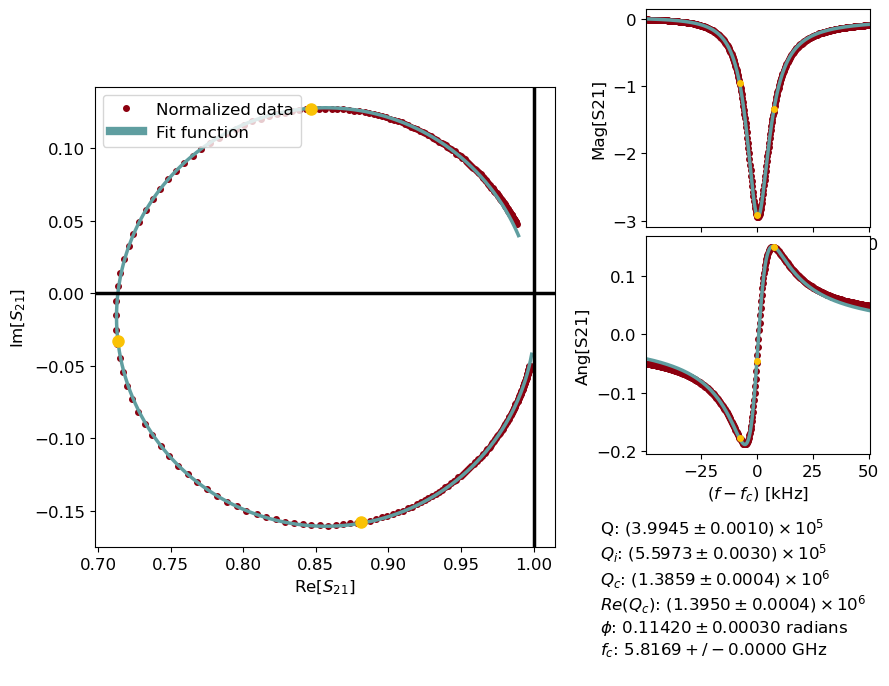

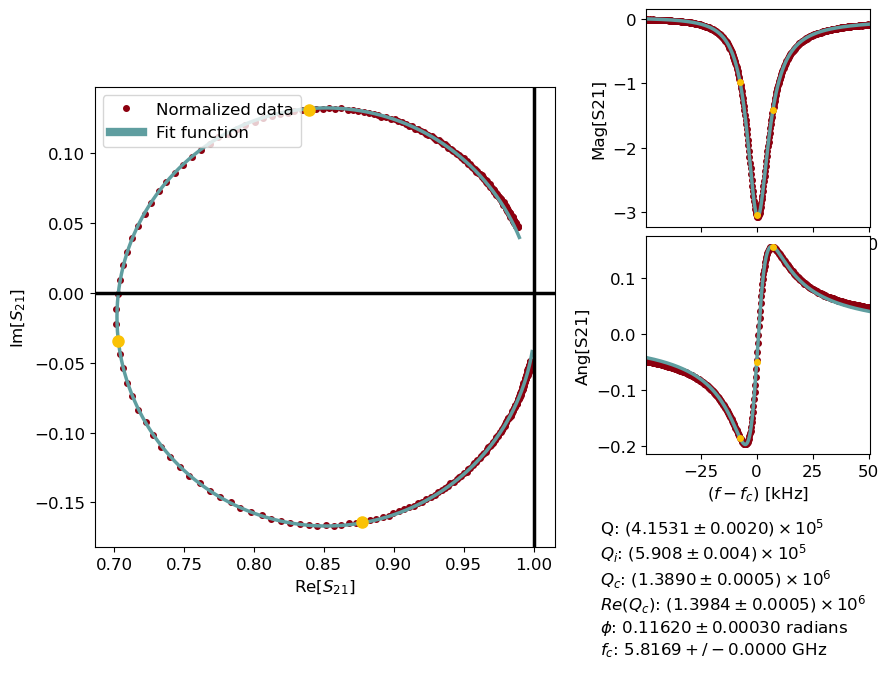

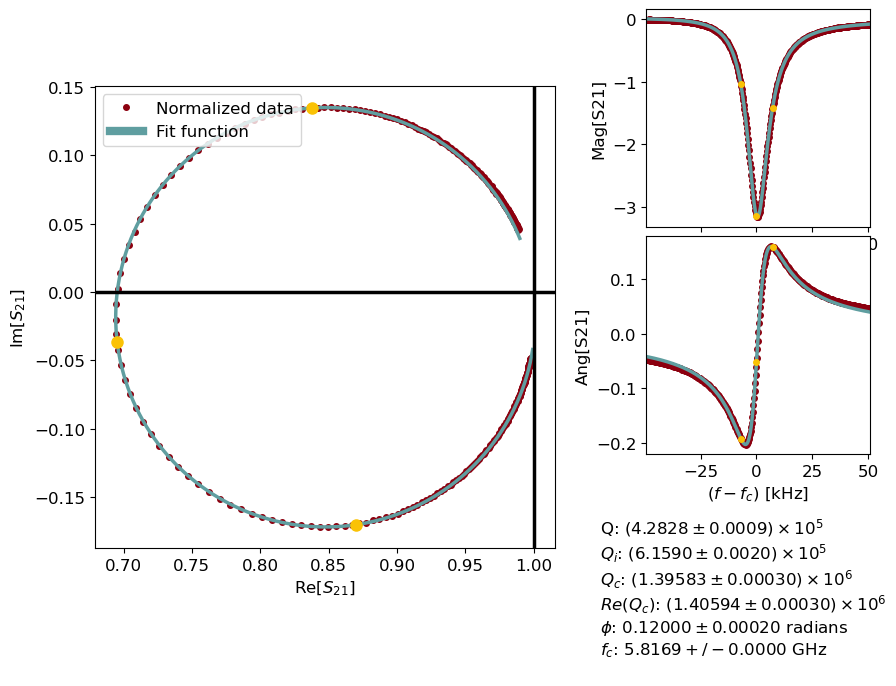

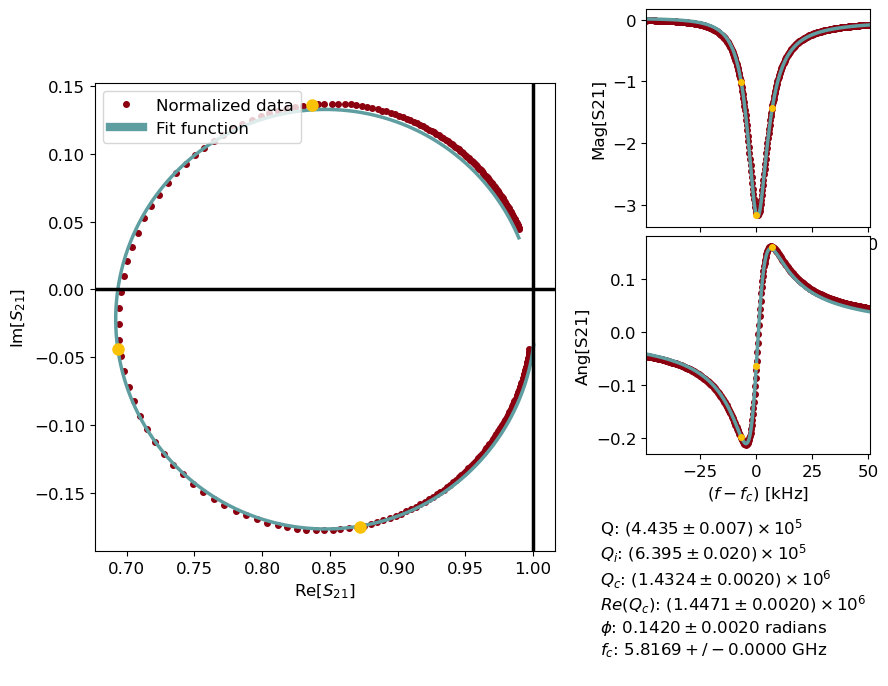

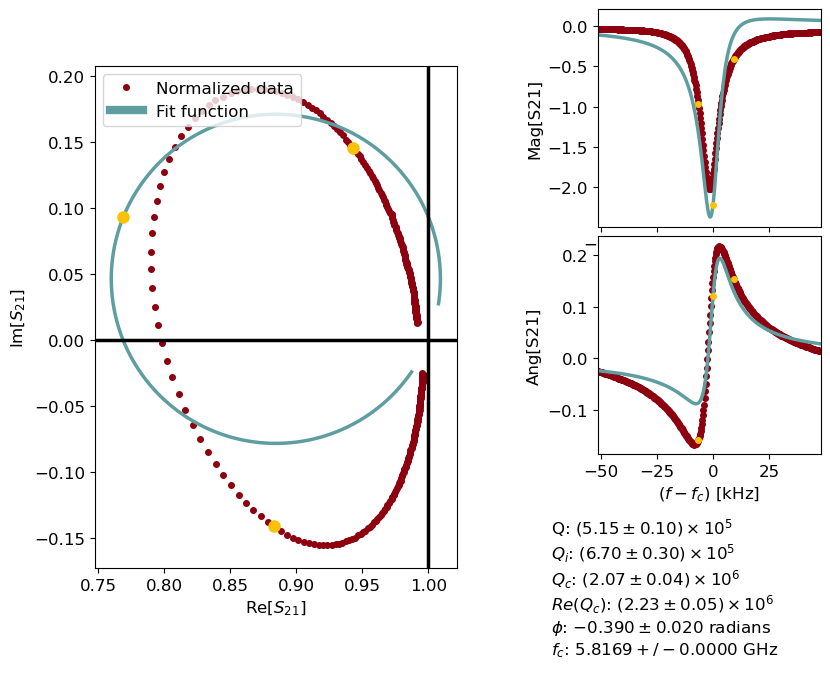

In [55]:
for i in range(len(file_list)):
    pth = pth_base       
    try:
        data, attrs = hy.prev_data(pth, file_list[i])
        # Reformat data for scres package
        data['phases'] = np.unwrap(data['phases'][0]*np.pi/180)
        data['freqs']=data['fpts'][0]
        data['amps']=data['mags'][0]

        output_path = '2409'
        pow_curr = data['vna_power'][0]     
        print(pow_curr)       
        output = fit_resonator(data, file_list[i], output_path, 'DCM')    
    except: 
        print('fit failed')  



### Fit single reosnator 

Qi is less than zero. Please make sure data is of correct format: decibals (log10*20 version), and radians. Otherwise, it is quite likely that the resonator being fit is not a Notch type resonator. Other types of resonators will not work with this code.


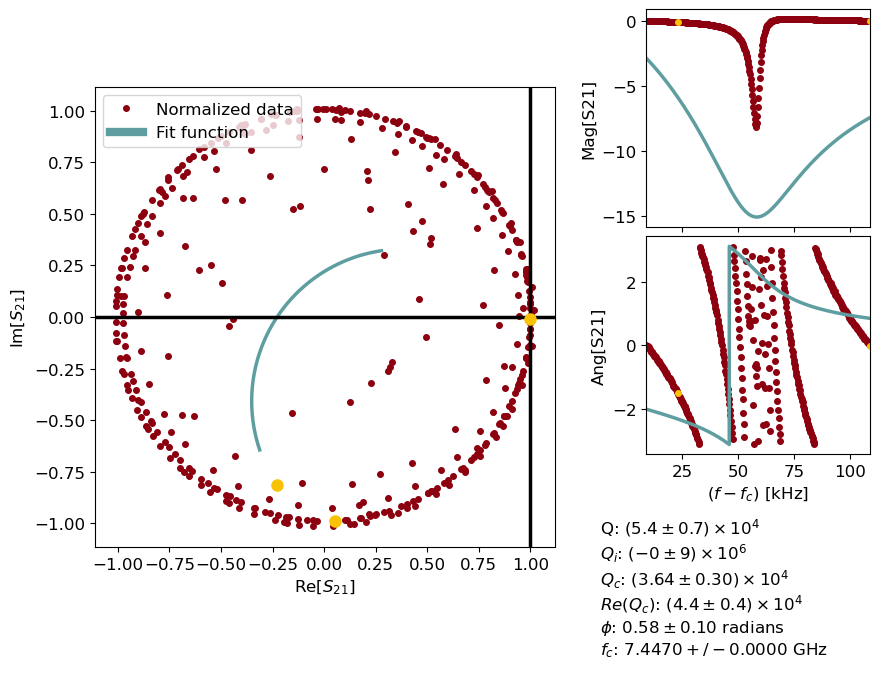

In [24]:
pth = pth_base     

data, attrs = hy.prev_data(pth, file_list[3])

# Reformat data for scres package
data['phases'] = np.unwrap(data['phases'][0])
data['freqs']=data['fpts'][0]
data['amps']=data['mags'][0]

output_path = '2409'
pow_curr = data['vna_power'][0]            
output = fit_resonator(data, file_list[3], output_path, 'DCM')   


### Plot raw amps, phases, circle

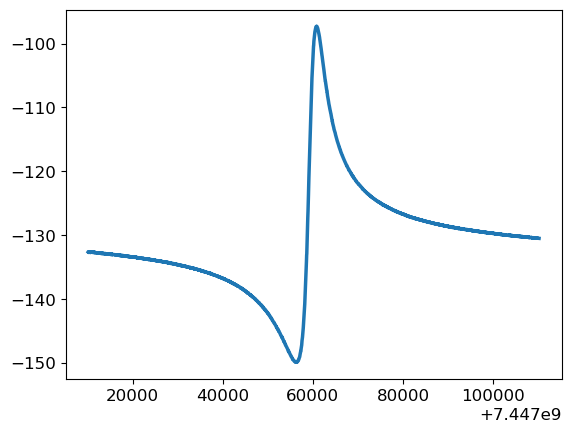

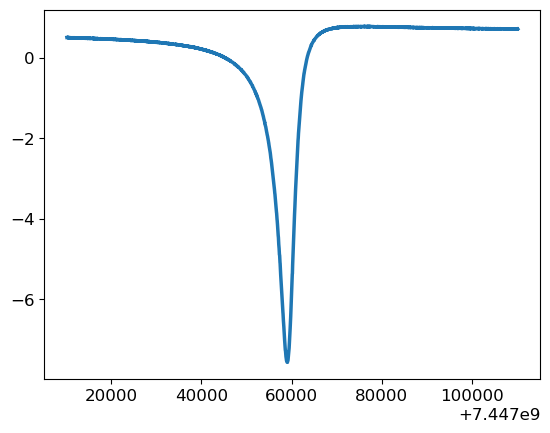

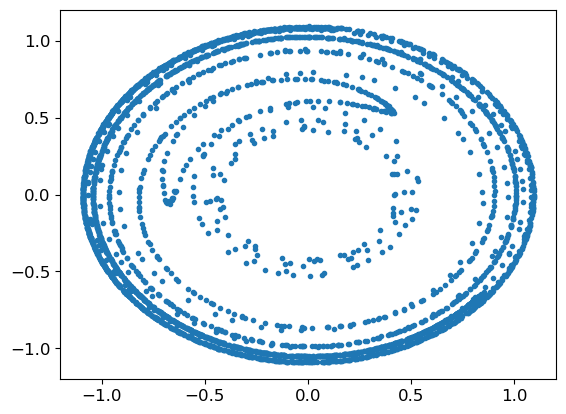

In [25]:
plt.plot(data['freqs'], data['phases']+2.46)

plt.figure()
#plt.plot(data['freqs'], 10**((data['amps']-36.64)/20))
plt.plot(data['freqs'], data['amps']-27.6)

phs = data['phases']+2.46
amp = 10**((data['amps']-27.6)/20)
plt.figure()
plt.plot(amp*np.cos(phs), amp*np.sin(phs), '.')

In [ ]:

fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 

j=0
for i in range(len(res_params)):
    ax[0].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:], '.-', label=round(np.min(res_params[i]['freqs']/1e9),4)) #str(temps[j])+ ' mK'    
    ax[1].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:]/np.max(res_params[i]['qi'][j,:]), '.-')

ax[0].legend()
ax[1].set_xlabel('Power')
ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_{i,max}$')
ax[0].set_title('120 mK')
fig.tight_layout()

fig.savefig('/Users/sph/' + 'Qi_pow2.png', dpi=300)


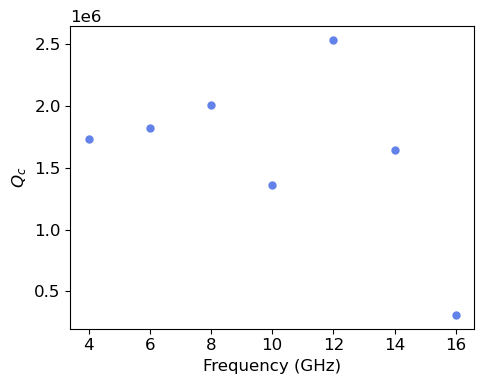

### Plot corrected data 

In [23]:
pth_base = '../../../../JJ_fab/Coherence Sample /Resonators Measurement/240719/data/sample1_power_sweep_2/'
#pth_base = '../../../../JJ_fab/Coherence Sample /Resonators Measurement/240719/data'

pattern0 = r'res_(\d+)_\d{2}dbm'
#pattern = r'res_(\d+)_\d{2}dbm'
resonators, file_list0 = get_resonators('', pattern0)

pattern = 'res_{:d}_'.format(resonators[5]) + '\d{2}dbm'
file_list = [file for file in file_list0 if re.match(pattern, file)]
#file_list = [file for file in file_list0 if re.search(pattern, file)]
file_list.sort()
file_list = file_list[::-1]
print(file_list)


114
Counter({6423087: 18, 6136373: 18, 5816871: 18, 7447060: 15, 7063648: 15, 7785143: 15, 6723184: 15})
['res_7447060_60dbm', 'res_7447060_50dbm', 'res_7447060_40dbm', 'res_7447060_30dbm', 'res_7447060_20dbm']


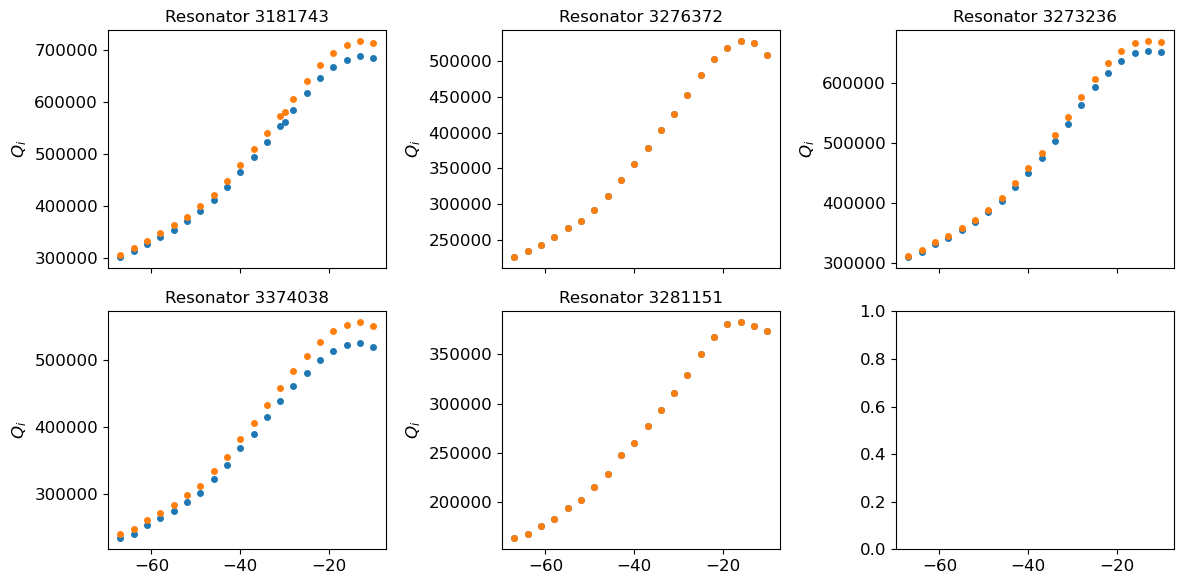

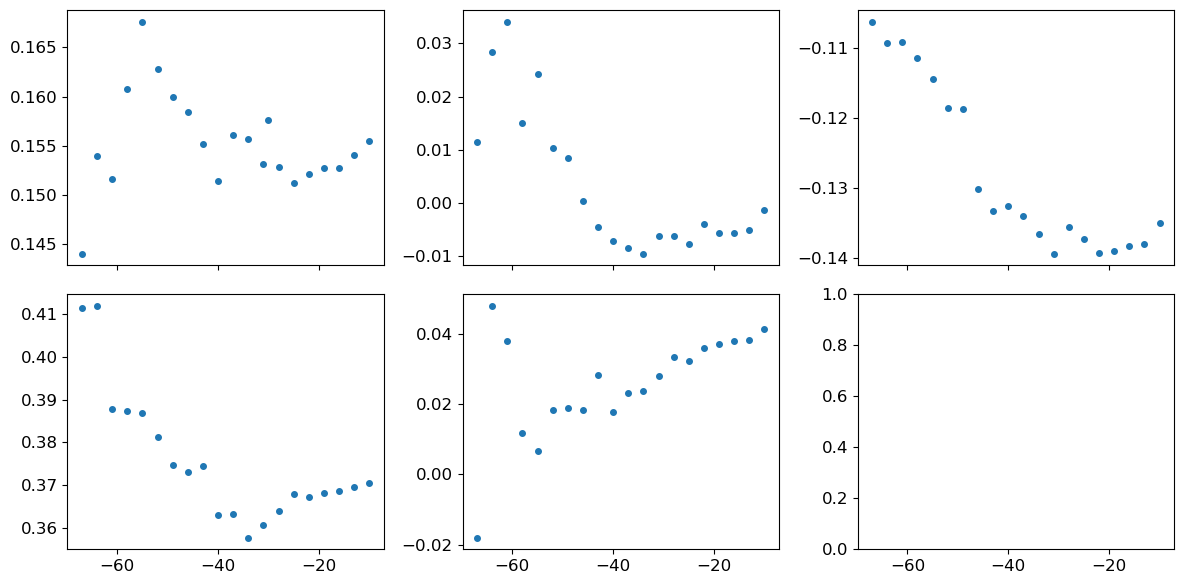

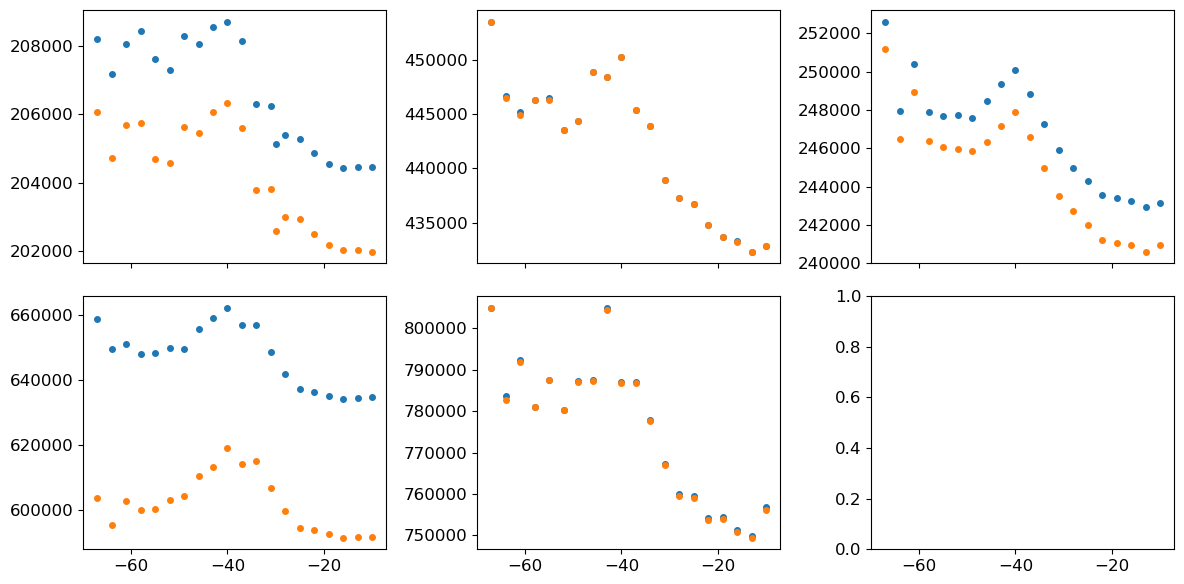

In [97]:
fig, ax = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax = ax.flatten()

fig2, ax2 = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax2 = ax2.flatten()

fig3, ax3 = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax3 = ax3.flatten()

for i in range(len(resonators)):
    inds=pow_list[i]>-70
    ax[i].plot(pow_list[i][inds], qi_list[i][inds], 'o', markersize=4)
    ax[i].plot(pow_list[i][inds], qi_phi_list[i][inds], 'o', markersize=4)
    ax2[i].plot(pow_list[i][inds], phs_list[i][inds], 'o', markersize=4)
    ax[i].set_title('Resonator {:d}'.format(resonators[i]))
    #ax[i].set_xlabel('Power (dBm)')
    ax[i].set_ylabel('$Q_i$')
    ax3[i].plot(pow_list[i][inds], qc_list[i][inds], 'o', markersize=4)
    ax3[i].plot(pow_list[i][inds], np.real(qc_list[i][inds]*np.exp(-1j*phs_list[i][inds])), 'o', markersize=4)


fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

### Fit TLS 

In [52]:
atten = -55

# def Qtls(n, T, w, Qtls0, b1, b2, D): 
#     return Qtls0 * np.sqrt(1 + n**b2 / (D*T**b1) * tp(w, T) / tp(w, T))

def pow_res(p): return 10**((p+atten)/10)*1e-3
def n(p,f, q,qc): return pow_res(p)*q**2/qc/(cs.h*f**2*np.pi)
def tp(f, T): return np.tanh(cs.h*f/(cs.k*T))
# T: temperature, nc: critical phonon number, f: frequency, Qtls0: TLS limit, beta: power law, n: photon number
def Qtls(n, T, f,  Qtls0, nc, beta): 
    return Qtls0/tp(f, T)*np.sqrt(1+(n/nc)**beta*tp(f, T))

def Qqp(T, f, Qqp0, Tc): return Qqp0*np.exp(1.764*Tc/T)/np.sinh(cs.h * f/2/cs.k/T)/special.kn(0,cs.h*f/2/cs.k/T)
#def n(p, f, q): return pow_res(p)*q/(cs.h*f**2*2*np.pi)

def Qtot(n, T, f, Qqp0, Qtls0, Qoth, Tc, beta, nc): 
    return 1/(1/Qqp(T, f, Qqp0, Tc) + 1/Qtls(n, T, f, Qtls0, beta, nc)+1/Qoth)

def Qtotn(n, T, f, Qtls0, Qoth, nc, beta): 
    return 1/(1/Qtls(n, T, f, Qtls0, nc,beta)+1/Qoth)
Tc = 9.288

#def nn2(p, qi, qc, f): pow_res(p)* qc* qi**2 / (np.pi * cs.h * f**2 * (qi + qc)**2)
# in Watts

# def Qtls(n, T, w, Qtls0, b1, b2, D): 
#     return Qtls0 * np.sqrt(1 + n**b2 / (D*T**b1) * tp(w, T) / tp(w, T))

#pow_res(pow_list[i])[0]

#print(pow_res(-70))
#pow_res(-70)*120e3/(cs.h*3.5e9**2*2*np.pi)
#pow_res(pow_list[i][0])*120e3/(cs.h*freq_list[i][0]**2*2*np.pi)


#nbar = n(pow_res(-10), freq_list[i][0], 120e3)
#print(nbar)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[845006.8475 736649.6584      1.1083      0.2256]


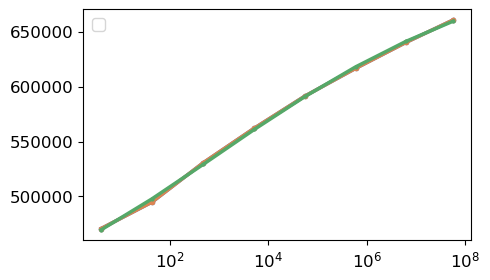

In [53]:
#for j in range(res_params[i]['pow'].shape[1]):
#def n(p,f, q,qc): return pow_res(p)*q**2/qc/(cs.h*f**2*np.pi)
#def Qtls(n, T, nc, f, Qtls0, beta): 
sns.set_palette("deep")
i=0
j=0
# photon numbers 
nn = n(res_params0[i]['pow'][j,:], res_params0[i]['freqs'][j,:], res_params0[i]['q'][j,:], res_params0[i]['qc'][j,:])
freq = res_params0[i]['freqs'][j,0]
#temp = temps[j]/1000
temp = 0.08
q_fit_tls = lambda n, Qtls0, nc, beta: Qtls(n, temp, freq, Qtls0, nc, beta)
q_fitn = lambda n, Qtls0, Qoth, nc, beta: Qtotn(n, temp, freq, Qtls0, Qoth, nc, beta)

p=[2e5, 6e5, .1, 0.3]
p2=[2.3e5,5e3, 0.2]

inds = res_params0[i]['pow'][j,:] < -10
qt = q_fitn(nn, *p)
qt2 = q_fit_tls(nn, *p2)

plt.figure(figsize=(5,3))
plt.semilogx(nn, res_params0[i]['qi'][j,:], '.-', markersize=6)

plt.semilogx(nn[inds], res_params0[i]['qi'][j,inds], '.-', markersize=6)
#plt.semilogx(nn[inds], qt[inds], '.-', label='Full Q')
#plt.semilogx(nn[inds], qt2[inds], '.-', label='Just TLS')

nn_list = np.logspace(-5,20)
plt.legend()

#plt.semilogx(nn_list, q_fitn(nn_list, *p), '.-', label='Just TLS')
params, err = curve_fit(q_fitn, nn[inds], res_params0[i]['qi'][j,inds], p0=p)
plt.semilogx(nn[inds], q_fitn(nn[inds], *params), '.-')

print(params)

In [ ]:
pow_arr =np.logspace(0,7)

nn = n(pow_arr, freq, res_params[i]['q'][j,:], res_params[i]['qc'][j,:])
#plt.semilogx(n(pow_arr, freq, ), q_fitn(n(pow_arr), 1e4, 2e5, 0.2), '.-')
#params, err = curve_fit(qtls_fit, nn[inds], res_params[i]['qi'][j,inds], p0=p)


In [150]:
#qtls_fit(nn[pow_arr], 1e4, 2e5, 0.2)


qt = qtls_fit(nn, 1e4, 2e5, 0.2)
print(qt)

IndexError: arrays used as indices must be of integer (or boolean) type

### Error

In [53]:
#[Q_conf, Qi_conf, Qc_conf, Qc_Re_conf, phi_conf, w1_conf]
err

phi_conf= np.array([err[i][4] for i in range(len(err))])
q_conf = np.array([err[i][0] for i in range(len(err))])
qi_conf = np.array([err[i][1] for i in range(len(err))])
qc_conf = np.array([err[i][2] for i in range(len(err))])
qc_re_conf = np.array([err[i][3] for i in range(len(err))])
w1_conf = np.array([err[i][5] for i in range(len(err))])


[0.001  0.0013 0.0152 0.0084 0.0012 0.0019 0.0023 0.0205 0.0017 0.0013
 0.0014 0.0303 0.0015 0.0033 0.0015 0.0015 0.002  0.0045 0.0026 0.0014
 0.0118 0.0061 0.0011 0.0019]
[  6.8372   9.0195 221.4433 109.68    10.3118  20.5725  18.8415 318.1558
  11.6155  12.7663  10.3914 363.0478  15.3654  37.8479  10.1259  11.7101
  13.9169  54.2356  29.141   10.4665 159.9295  77.0622   7.8443  16.5252]
[  742.4089   995.978  12065.8691  6865.8273   925.8305  1510.9545
  1780.9077 16145.9536  1245.4735  1046.0238  1072.6401 27686.6296
  1199.4234  2564.5891  1120.2134  1149.8855  1499.7289  3594.2913
  2078.0793  1056.4185  9620.796   4815.3662   850.9024  1492.8974]
[ 805.8354 1002.905  3252.2629 2085.0751  487.4673  626.4712 1133.349
 4022.6614 1335.608   504.8302  914.2466 6156.959   534.1541  932.4858
 1189.3695  805.5279 1559.7406 1215.4463  807.7474  817.3501 2694.1902
 1552.8273  796.0797  864.8849]


### Single Resonator

res_3181743_61dbm


-61.0

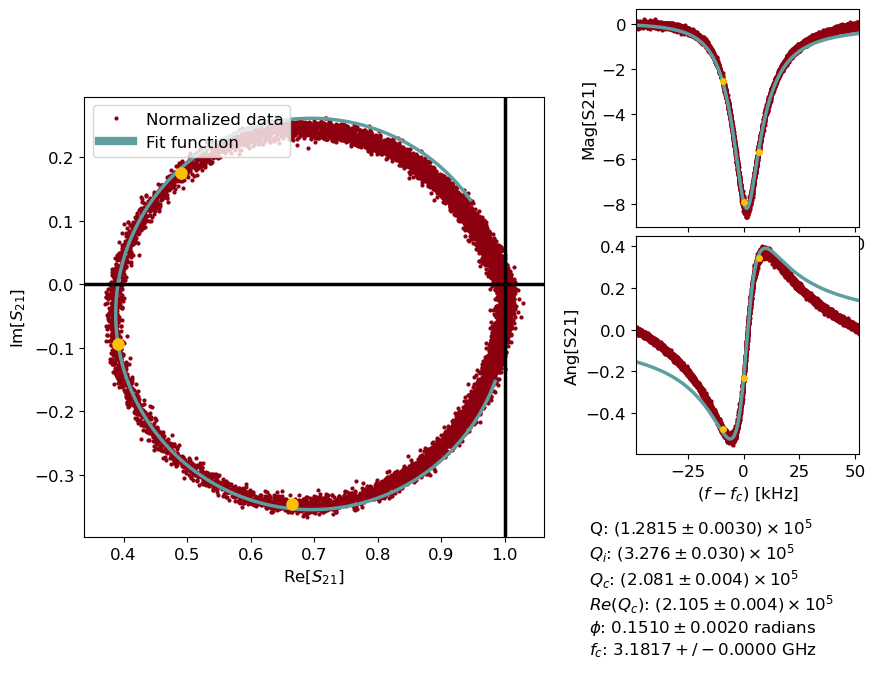

<Figure size 1000x800 with 0 Axes>

In [153]:
i=3
output_path = './procdata_' + folder + '/'

pattern = 'res_{:d}_'.format(resonators[0]) + '\d{2}dbm'
file_list = [file for file in file_list0 if re.search(pattern, file)]

data, attrs = prev_data(pth, file_list[i])

data['phases'] = np.unwrap(data['phases'][0])
data['freqs']=data['fpts'][0]
data['amps']=data['mags'][0]

print(file_list[i])
output = fit_resonator(data, file_list[i], output_path, 'DCM')    

plt.figure()
#plt.plot(data['freqs'], data['phases'], '.')
#plt.plot(data['freqs'], data['amps'], '.')
data['vna_power'][0]
#cpzm  226k / 736 [DOESN'T FIT WELL]
# phi 206 / 539
# DCM 206 / 523
# INv 202 / 520 

#QI

## Plot resonator data

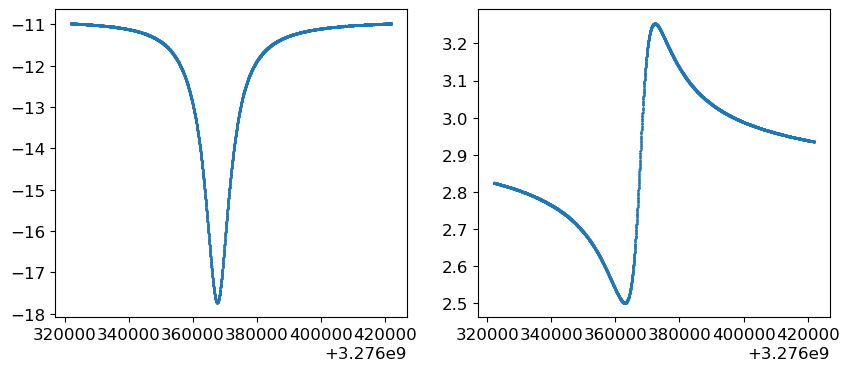

In [9]:
data = read_file(pth, file_list[20])
data['phases'] = np.unwrap(data['phases'])#*180/np.pi
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(data['freqs'], data['amps'],'.')
ax[1].plot(data['freqs'], data['phases'],'.')

/var/folders/00/4dhzg6ms0xl3w8qywb_l4_nw0000gn/T/ipykernel_12208/693412827.py:13: RuntimeWarning: invalid value encountered in power
  return Qtls0/tp(2*np.pi*f, T)*np.sqrt(1+(n/nc)**beta*tp(2*np.pi*f, T))
/var/folders/00/4dhzg6ms0xl3w8qywb_l4_nw0000gn/T/ipykernel_12208/693412827.py:13: RuntimeWarning: invalid value encountered in sqrt
  return Qtls0/tp(2*np.pi*f, T)*np.sqrt(1+(n/nc)**beta*tp(2*np.pi*f, T))


[     0.0302   1284.7107 206589.5936      0.1974]


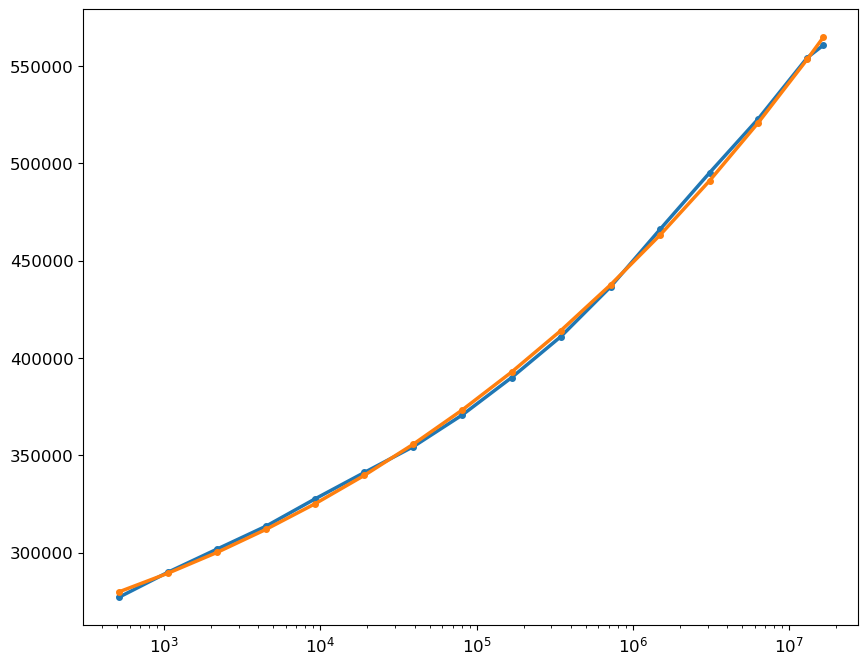

In [269]:
from scipy.optimize import curve_fit
q = 1/(1/qi_list[i]+1/qc_list[i])
i=0
#def Qtls(n, T, nc, f, Qtls0, beta): 
plt.figure()
inds = np.arange(2,18)
pow=nn(pow_list[i][inds], q[inds], qc_list[i][inds], freq_list[i][inds])
plt.semilogx(pow, qi_list[i][inds], 'o-', markersize=4)
#p, cov = curve_fit(Qtls, pow, qi_list[i][inds], [2e5, ])
p=[0.08, 1e4, 3e5, 0.3]
f = freq_list[i][0]
def Qtls(n, T, nc, Qtls0, beta): 
    return Qtls0/tp(2*np.pi*f, T)*np.sqrt(1+(n/nc)**beta*tp(2*np.pi*f, T))
pow_res(pow_list[i])[0]
p, cov = curve_fit(Qtls, pow, qi_list[i][inds], p)

plt.semilogx(pow, Qtls(pow, *p), 'o-', markersize=4)
print(p)

In [151]:
qc_mean = np.array([np.mean(qc_list[i]) for i in range(len(qc_list))])
freq_mean = np.array([np.mean(freq_list[i]) for i in range(len(freq_list))])
qc_mean2 = np.array([np.mean(df_list[i]['Qc']) for i in range(len(df_list))])
qi_0 = np.array([np.min(qi_list[i][pow_list[i]>-70]) for i in range(len(qc_list))])

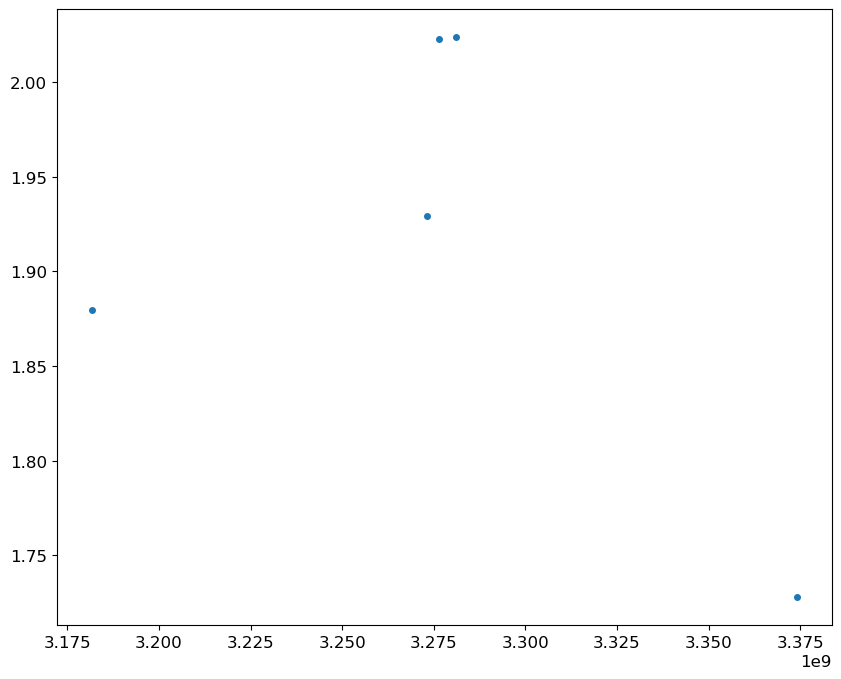

In [121]:
plt.figure
plot_full = False
if plot_full:
    plt.plot(freq_mean, qc_mean, 'o', markersize=4, label='DCM')
    plt.plot(freq_mean, qc_mean2, 'o', markersize=4, label='AO')
else:
    plt.plot(freq_mean, qc_mean2/qc_mean, 'o', markersize=4, label='AO')